# Analysis

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

In [20]:
# Pull and clean up traffic data for a city
def convert_traffic_data(city):
    # Load {city}.csv
    city_data = pd.read_csv(f'dataset/cities/{city}.csv')

    city_data['interval'] = city_data['interval'].apply(lambda x: f'{x // 3600}:{x % 3600 // 60}:{x % 60}')
    city_data['datetime'] = pd.to_datetime(city_data['day'] + ' ' + city_data['interval'], format='%Y-%m-%d %H:%M:%S')

    date_time = pd.to_datetime(city_data['day'] + ' ' + city_data['interval'])

    # Convert the datetime column to a timestamp
    timestamp = date_time.map(pd.Timestamp.timestamp)

    # Add the sin and cos of the day, week and year to the dataframe
    day = 24 * 60 * 60
    week = day * 7
    year = day * 365.2425
    city_data['day_sin'] = np.sin(timestamp * (2 * np.pi / day))
    city_data['day_cos'] = np.cos(timestamp * (2 * np.pi / day))
    city_data['week_sin'] = np.sin(timestamp * (2 * np.pi / week))
    city_data['week_cos'] = np.cos(timestamp * (2 * np.pi / week))
    city_data['year_sin'] = np.sin(timestamp * (2 * np.pi / year))
    city_data['year_cos'] = np.cos(timestamp * (2 * np.pi / year))

    # Drop the datetime and timestamp columns
    city_data = city_data.drop(columns=['interval', 'day', 'error', 'speed'])
    city_data = city_data.set_index(['city', 'detid', 'datetime'])

    return city_data

In [21]:
city_data = convert_traffic_data('basel')
city_data.head()

flow    occ   day_sin   day_cos  week_sin  \
city  detid    datetime                                                         
basel 135D1_9  2016-10-24 00:05:00  36.0  0.010  0.021815  0.999762  -0.43669   
      135D3_8  2016-10-24 00:05:00   0.0  0.001  0.021815  0.999762  -0.43669   
      135D6_8  2016-10-24 00:05:00  36.0  0.016  0.021815  0.999762  -0.43669   
      135Stau1 2016-10-24 00:05:00  24.0  0.008  0.021815  0.999762  -0.43669   
      135Stau5 2016-10-24 00:05:00  12.0  0.006  0.021815  0.999762  -0.43669   

                                    week_cos  year_sin  year_cos  
city  detid    datetime                                           
basel 135D1_9  2016-10-24 00:05:00 -0.899612 -0.923293  0.384097  
      135D3_8  2016-10-24 00:05:00 -0.899612 -0.923293  0.384097  
      135D6_8  2016-10-24 00:05:00 -0.899612 -0.923293  0.384097  
      135Stau1 2016-10-24 00:05:00 -0.899612 -0.923293  0.384097  
      135Stau5 2016-10-24 00:05:00 -0.899612 -0.923293  0.384097

In [22]:
# Expand detector data
def expand_detector_data(city_data):
    # Load detectors.csv
    detectors = pd.read_csv('dataset/detectors.csv').set_index(['citycode', 'detid'])

    # Add the detector data to the city data
    city_data = city_data.join(detectors, on=['city', 'detid'])
    city_data['linkid'] = city_data['linkid'].astype('int64')
    city_data['limit'] = city_data['limit'].astype('int64')

    # Drop the detector id column
    city_data = city_data.reset_index().drop(columns=['road', 'long', 'lat', 'detid']).set_index(['city', 'linkid', 'datetime'])

    # Convert the fclass column to a range
    fclass_ids = [
        'other', 
        'living_street', 
        'residential', 
        'service', 
        'tertiary_link', 
        'tertiary', 
        'secondary_link',
        'secondary', 
        'primary_link', 
        'primary',
        'trunk_link',
        'trunk', 
        'motorway_link', 
        'motorway'
    ]
    city_data['fclass'] = city_data['fclass'].apply(lambda x: fclass_ids.index(x))

    return city_data

In [23]:
city_data = expand_detector_data(city_data)
city_data.head()

flow    occ   day_sin   day_cos  week_sin  \
city  linkid datetime                                                         
basel 49     2016-10-24 00:05:00  36.0  0.010  0.021815  0.999762  -0.43669   
      47     2016-10-24 00:05:00   0.0  0.001  0.021815  0.999762  -0.43669   
      51     2016-10-24 00:05:00  36.0  0.016  0.021815  0.999762  -0.43669   
      50     2016-10-24 00:05:00  24.0  0.008  0.021815  0.999762  -0.43669   
      48     2016-10-24 00:05:00  12.0  0.006  0.021815  0.999762  -0.43669   

                                  week_cos  year_sin  year_cos    length  \
city  linkid datetime                                                      
basel 49     2016-10-24 00:05:00 -0.899612 -0.923293  0.384097  0.216641   
      47     2016-10-24 00:05:00 -0.899612 -0.923293  0.384097  0.307133   
      51     2016-10-24 00:05:00 -0.899612 -0.923293  0.384097  0.150163   
      50     2016-10-24 00:05:00 -0.899612 -0.923293  0.384097  0.510887   
      48     2016-10-24 00:05:00 -0.899612 -0.923293  0.384097  0.212557   

                                       pos  fclass  limit  lanes  
city  linkid datetime                                             
basel 49     2016-10-24 00:05:00  0.062287       5     30    1.0  
      47     2016-10-24 00:05:00  0.074653       5     50    1.0  
      51     2016-10-24 00:05:00  0.058680       0     30    1.0  
      50     2016-10-24 00:05:00  0.448325       5     30    1.0  
      48     2016-10-24 00:05:00  0.147724       5     30    1.0

In [24]:
# Split the data into training, validation and test sets
def split_data(city_data):
    from sklearn.model_selection import train_test_split

    # Split the data into training, validation and test sets
    train_data, test_data = train_test_split(city_data, test_size=0.2, shuffle=False)
    train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(city_data)

In [25]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                                enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='flow', max_subplots=3):
        import matplotlib.pyplot as plt

        inputs, labels = self.example()
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [min]')

  
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
  
    def train(self):
        return self.make_dataset(self.train_df)

    def val(self):
        return self.make_dataset(self.val_df)

    def test(self):
        return self.make_dataset(self.test_df)

    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train()))
            # And cache it for next time
            self._example = result
        return result
    
window = WindowGenerator(input_width=12, label_width=12, shift=1, label_columns=['flow', 'occ'])
window

Total window size: 13
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Label column name(s): ['flow', 'occ']

In [26]:
# Create an LSTM model
def create_model(input_shape):
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Dropout

    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=True),
        Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mean_absolute_error', 'mean_squared_error']
    )

    return model

# Create the model for hourly predictions
model = create_model(input_shape=(window.label_width, len(window.train_df.columns)))
model.summary()
print(model.input_shape)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 32)            5888      
                                                                 
 dense_2 (Dense)             (None, 12, 1)             33        
                                                                 
Total params: 5921 (23.13 KB)
Trainable params: 5921 (23.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
(None, 12, 13)


In [28]:
# Train the model
def train_model(model, window, epochs=10):
    from keras.callbacks import EarlyStopping

    early_stop = EarlyStopping(monitor='val_loss', patience=10)

    # Print model inputs and outputs
    print(f'Inputs: {model.input_shape}')
    print(f'Outputs: {model.output_shape}')

    history = model.fit(
        window.train(),
        epochs=epochs,
        validation_data=window.val(),
        callbacks=[early_stop]
    )

    return history

history = train_model(model, window)

Inputs: (None, 12, 13)
Outputs: (None, 12, 1)
Epoch 1/10
3105/3105 [==============================] - 50s 16ms/step - loss: 26066.1348 - mean_absolute_error: 101.2747 - mean_squared_error: 26066.1113 - val_loss: 22725.0684 - val_mean_absolute_error: 105.0163 - val_mean_squared_error: 22725.0957
Epoch 2/10
3105/3105 [==============================] - 51s 17ms/step - loss: 23467.0898 - mean_absolute_error: 103.4584 - mean_squared_error: 23467.1230 - val_loss: 21590.6191 - val_mean_absolute_error: 105.1412 - val_mean_squared_error: 21590.6172
Epoch 3/10
3105/3105 [==============================] - 51s 16ms/step - loss: 22303.9199 - mean_absolute_error: 102.0323 - mean_squared_error: 22303.9062 - val_loss: 20648.7188 - val_mean_absolute_error: 103.5791 - val_mean_squared_error: 20648.7129
Epoch 4/10
3105/3105 [==============================] - 54s 17ms/step - loss: 21264.1328 - mean_absolute_error: 99.9371 - mean_squared_error: 21264.0801 - val_loss: 20133.4199 - val_mean_absolute_error: 1

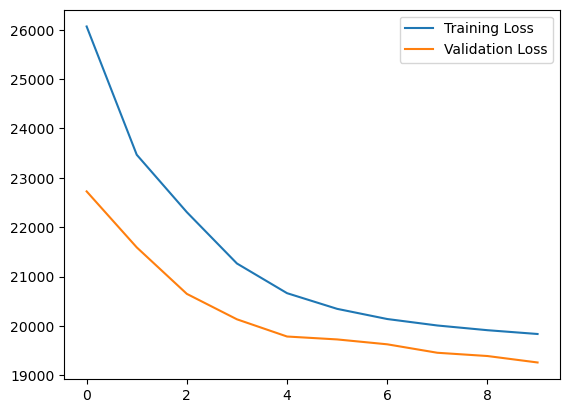

In [29]:
# Plot the training and validation loss
def plot_loss(history):
    import matplotlib.pyplot as plt

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

plot_loss(history)

970/970 [==============================] - 9s 9ms/step - loss: 13346.4150 - mean_absolute_error: 82.1153 - mean_squared_error: 13346.4053


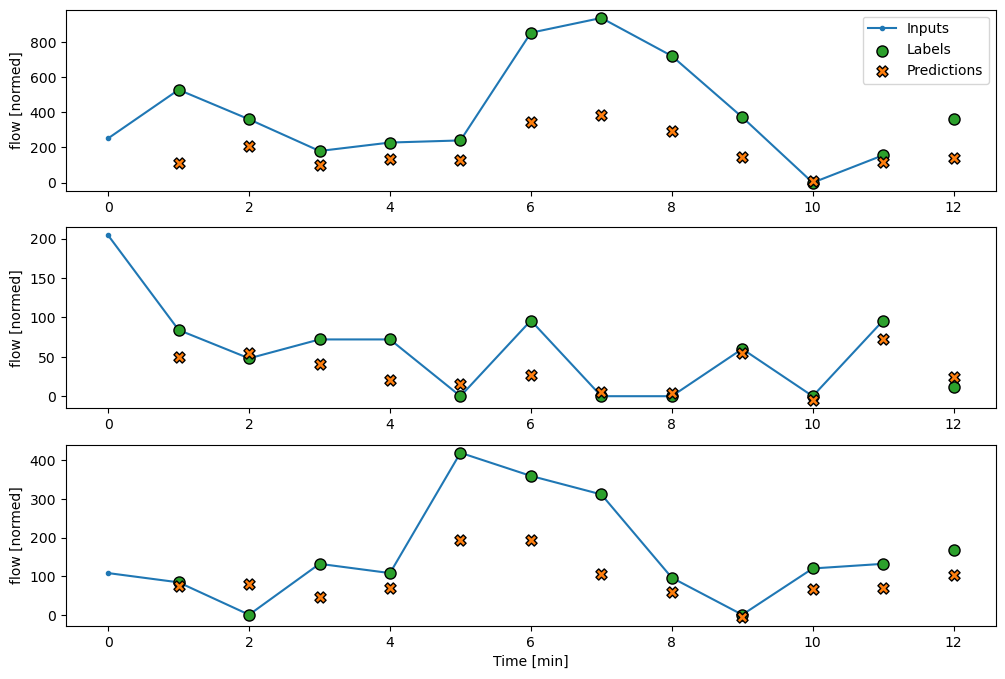

In [30]:
# Compute the test loss
def compute_test_loss(model, window):
    loss = model.evaluate(window.test())
    return loss

loss = compute_test_loss(model, window)
window.plot(model)

In [31]:
# Save the model
model.save("model.keras")

## Producing Inferences from the Model

In [32]:
# Load the model
model = keras.models.load_model("model.keras")

1/1 [==============================] - 0s 202ms/step


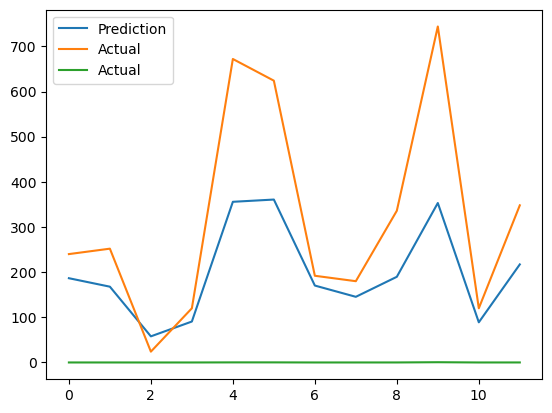

1/1 [==============================] - 0s 13ms/step


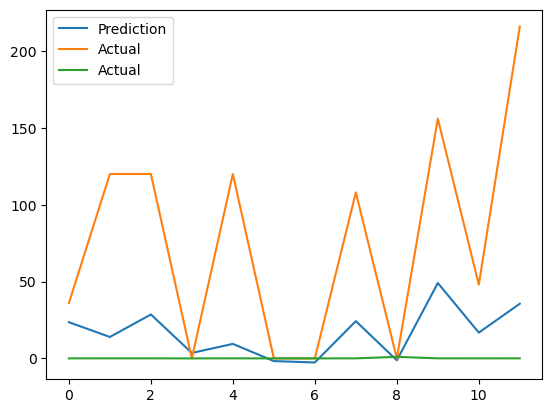

1/1 [==============================] - 0s 13ms/step


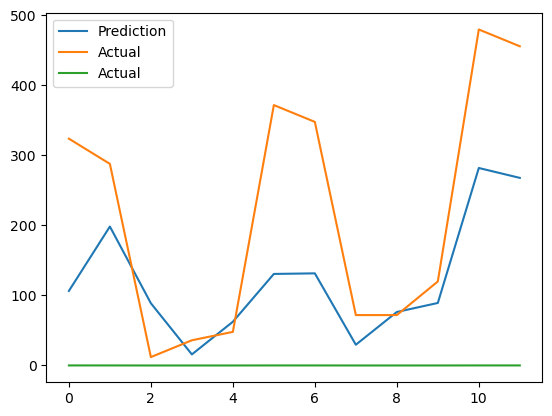

In [33]:
# Plot the predictions
def plot_predictions(model, window):
    import matplotlib.pyplot as plt

    for x, y in window.test().take(3):
        prediction = model.predict(x)
        plt.plot(prediction[0], label='Prediction')
        plt.plot(y[0], label='Actual')
        plt.legend()
        plt.show()

plot_predictions(model, window)